In [1]:
%load_ext autoreload
%autoreload 2

TODO: 
    stain normaliztion
    augmantation
    

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge
from keras.applications import VGG16, VGG19, InceptionV3, Xception, ResNet50

%matplotlib inline

Using TensorFlow backend.


In [3]:
from keras.layers import Dense, concatenate
from keras.models import Model, load_model

In [4]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc

W0522 20:02:03.179841 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:1: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



In [12]:
from utils.load_data import load_data
from utils.preprocess import DataGenerator
from utils.comparams import calculate_auc, auc

### Data Generator

In [6]:
data_dir = './data/'

In [7]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=10000)
len(x_train), len(x_valid)

(10000, 10000)

In [8]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [9]:
del train_id
del val_id
del data_dir

## MODEL

In [10]:
model_vgg16 = load_model('Model/vgg16_model_10k.h5')
for i, layer in enumerate(model_vgg16.layers):
    model_vgg16.layers[i].trainable = False
    model_vgg16.layers[i].name = '{}_{}'.format(layer.name, 'vgg16')
vgg16_out = model_vgg16.output

W0522 20:03:58.402439 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0522 20:03:58.422655 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0522 20:03:58.440139 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0522 20:03:58.632543 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The

In [14]:
dependencies = {
    'auc': auc
}

In [16]:
model_vgg19 = load_model('Model/vgg19_model_10K_lrr_0-001.h5', custom_objects=dependencies)
# model = model_from_json(open(network_filepath).read())
# model.load_weights(os.path.join(os.path.dirname(network_filepath)))
for i, layer in enumerate(model_vgg19.layers):
    model_vgg19.layers[i].trainable = False
    model_vgg19.layers[i].name = '{}_{}'.format(layer.name, 'vgg19')
vgg19_out = model_vgg19.output

## NASNET

In [17]:
nasnet = NASNetLarge(weights='imagenet', include_top=False)

W0522 22:24:49.097790 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0522 22:24:49.499449 139772595912832 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [19]:
inputs = Input((224, 224, 3))
x = nasnet(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

W0522 22:25:43.577364 139772595912832 deprecation.py:506] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
for layer in nasnet.layers:
    layer.trainable = False
nasnet_model = Model(inputs=inputs, outputs=y)



In [22]:
nasnet_model.load_weights('Model/weights/nasnet_modelbest_acc_model.h5')

In [26]:
for i, layer in enumerate(nasnet_model.layers):
    nasnet_model.layers[i].trainable = False
    nasnet_model.layers[i].name = '{}_{}'.format(layer.name, 'nasnet')
nasnet_out = nasnet_model.output

# Concat

In [27]:
merge_0 = concatenate([vgg16_out, vgg19_out, nasnet_out])
output = Dense(2, activation='sigmoid', name='main_output')(merge_0)
model = Model(inputs=[model_vgg16.input, model_vgg19.input, nasnet_model.input], outputs=output)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_vgg19 (InputLayer)      (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_vgg19 (Conv2D)     (None, 224, 224, 64) 1792        input_1_vgg19[0][0]              
__________________________________________________________________________________________________
block1_conv2_vgg19 (Conv2D)     (None, 224, 224, 64) 36928       block1_conv1_vgg19[0][0]         
__________________________________________________________________________________________________
input_1_vgg16 (InputLayer)      (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_poo

### Data Generator

In [64]:
data_dir = './data/'

In [65]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=10000)
len(x_train), len(x_valid)

(10000, 10000)

In [66]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [67]:
del train_id
del val_id
del data_dir

In [68]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [69]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
# 0.002 0.02 2e-5 0.001
# optimizer=Adam(lr=0.0002, decay=0.00001),
#               loss='binary_crossentropy',
#               metrics=['accuracy']
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [70]:
model.compile(optimizer, loss, metrics)

## Train the model

In [71]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'ensemble_model'
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

In [81]:

def multiple_batch_generator(generator_num, **kwargs):
    """A generator to work with multiple inputs models
    
    We create a model with a list of multiple input layers when 
    we use :func:`keras.layers.concatenate`. However,
    :class:`batch_generator.BatchGenerator` returns a single tuple 
    with two arrays, which does not fit to a model with a multiple 
    input layers. Thus, with this generator, we create the necessary 
    input for such models.
    
    Arguments:
        generator_num {int} -- number of generators should be created
        \**kwargs -- See :class:`batch_generator.BatchGenerator`
        
    Yields:
        ([ndarray,...,ndarray], ndarray) -- in the tuple; list contains feature arrays from each generator, array out of the list contains the label set
    """
    #generators_list = [BatchGenerator(**kwargs, shuffle=False) for i in range(generator_num)]
    gen = DataGenerator(**kwargs, shuffle=False)
    
    i = 0
    while i < gen.__len__():
        nx = gen.__getitem__(i)
        Xy_list = [nx]*generator_num
        i += 1
        yield [Xy[0] for Xy in Xy_list], Xy_list[0][1]

 list_IDs, data, labels, batch_size=32, dim=(224, 224), n_channels=3

In [82]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
#     'shuffle': True
}

# Generators
training_generator = multiple_batch_generator(generator_num=3, list_IDs=partition['train'], data=x_train, labels=train_labels, **params)
validation_generator = multiple_batch_generator(generator_num=3, list_IDs=partition['validation'], data=x_valid, labels=val_labels, **params)

# #a function to save last_model compatible with the on_interrupt handler of TimerCallback
# def saveWeights(model, elapsed):
#     model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [83]:
val_steps= int(len(y_valid)/batch_size)

<Figure size 720x360 with 0 Axes>

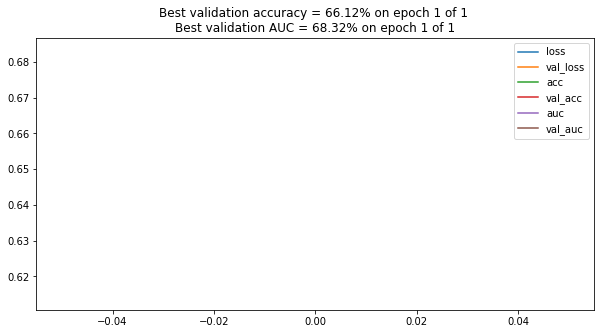

Epoch 2/10


StopIteration: 

In [84]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks, steps_per_epoch=steps, validation_steps= val_steps)

# Calculate AUC

In [20]:
data_dir = './data'
# data_dir = './data'

x_test, y_test_true = load_data(data_dir, purpose='test')#, norm='macenko')

# indexes
test_id = np.arange(len(x_test))

# create a useful dictionary structures
partition = {}
partition['test'] = test_id
    
test_labels = {str(i) : y_test_true[i].flatten()[0] for i in test_id}

len(test_labels)

32768

In [21]:
# Define batch size.
batch_size = 128

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

# Generators
test_generator = DataGenerator(partition['test'], x_test, test_labels, **params)

preds = model.predict_generator(test_generator)

In [22]:
true_labels = np.array(y_test_true).flatten()

pred_labels = np.array([p[1] for p in preds])

calculate_auc(true_labels, pred_labels)

sklearn auc: 0.87086285901174
tf auc: [0.8704897, 0.8704897]
